In [ ]:
# imports
import json
import pandas as pd
import seaborn as sns
from matplotlib import ticker, pyplot as plt
from datetime import datetime, timedelta
from parse import get_logs_json

In [2]:
# prepare json data
records = []
for m in get_logs_json():
    for stat in m["stats"]:
        records.append({
            "measurement_id": m["measurement_id"],
            "server": m["server"],
            "nic": m["nic"],
            "nt": m["nt"],
            "start_time": m["start_time"],
            "timestamp": stat["timestamp"],
            "fps": stat.get("framesPerSecond"),
            "frame_delivery_ms": stat.get("frameDeliveryTimeMs"),
            "frame_queue_ms": stat.get("frameQueueTimeMs"),
            "frame_latch_ms": stat.get("frameLatchTimeMs"),
            "bandwidth_available_kbps": stat.get("bandwidthAvailableKbps"),
            "bandwidth_kbps": stat.get("bandwidthUtilizationKbps"),
            "bandwidth_percent": stat.get("bandwidthUtilizationPercent"),
            "rtt_ms": stat.get("roundTripDelayMs"),
            "jitter_us": stat.get("jitterUs"),
            "packets_received": stat.get("totalPacketsReceived"),
            "packets_lost": stat.get("totalPacketsLost"),
            "packets_dropped": stat.get("totalPacketsDropped"),
            "quality": stat.get("quality"),
            "qualityReasons": stat.get("qualityReasons", 0),
        })
df = pd.DataFrame(records)

def location(measurement_id):
    if str(measurement_id).startswith("1."):
        return "TMIT 1"
    elif str(measurement_id).startswith("2."):
        return "TMIT 2"
    elif str(measurement_id).startswith("3."):
        return "SCH 15"
    return "unknown"

def location2(row):
    if str(row["measurement_id"]).startswith(("1.", "2.")):
        return "TMIT"
    elif str(row["measurement_id"]).startswith("3."):
        return "SCH"
    return "unknown"

def server_group(ip):
    if ip in ["10.6.6.50", "152.66.244.166"]:
        return "tmit_local_1660ti"
    elif ip in ["35.240.22.113", "35.187.102.8"]:
        return "gcloud_belgium_p100"
    return "other"

def normalize_times_millis(row):
    fmt = "%H:%M:%S.%f"
    t0 = datetime.strptime(row["start_time"], fmt)
    t = datetime.strptime(row["timestamp"].strftime(fmt), fmt)
    return int((t - t0).total_seconds() * 1000)

df["location"] = df["measurement_id"].apply(location)
df["location2"] = df.apply(location2, axis=1)
df["server_group"] = df["server"].apply(server_group)
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%H:%M:%S.%f").dt.time
df["time_ms"] = df.apply(normalize_times_millis, axis=1)


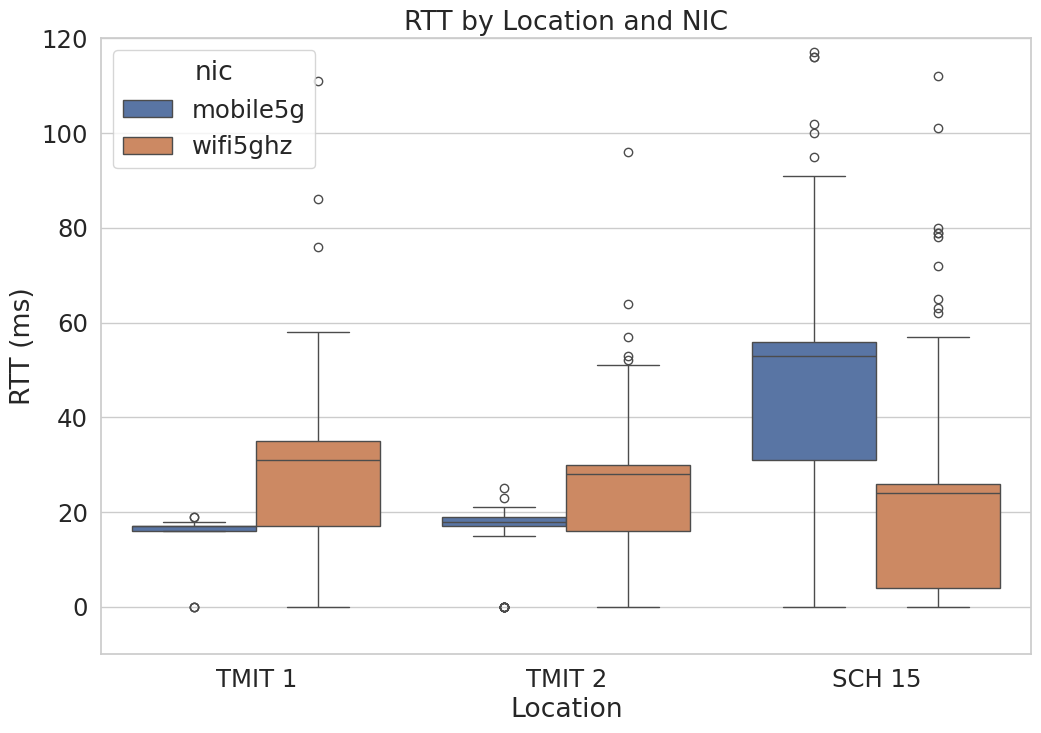

In [3]:
# rtt boxplot
sns.set(style="whitegrid", font_scale=1.6)
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df, x="location", y="rtt_ms", hue="nic")
ax.set_ylim(top=120, bottom=-10)
plt.xlabel("Location")
plt.ylabel("RTT (ms)")
plt.title("RTT by Location and NIC")
plt.savefig('figures/rtt_boxplot.png')
plt.show()

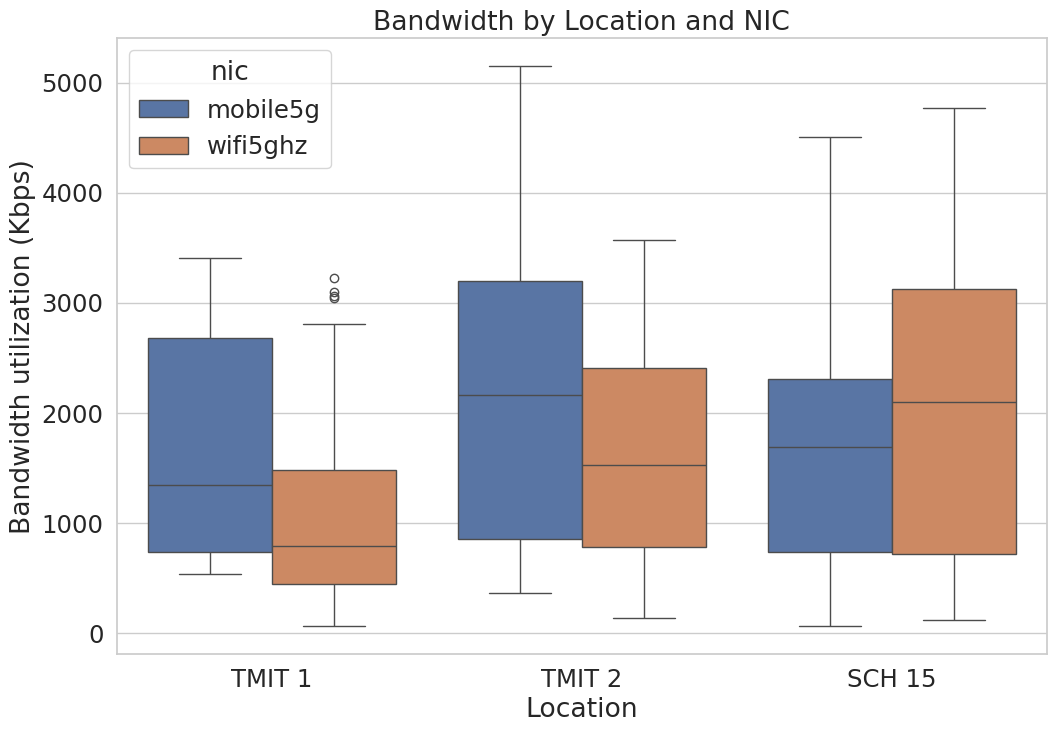

In [4]:
# bw boxplot
sns.set(style="whitegrid", font_scale=1.6)
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df, x="location", y="bandwidth_kbps", hue="nic")
#ax.set_ylim(top=120, bottom=-10)
plt.xlabel("Location")
plt.ylabel("Bandwidth utilization (Kbps)")
plt.title("Bandwidth by Location and NIC")
plt.savefig('figures/bw_boxplot.png')
plt.show()

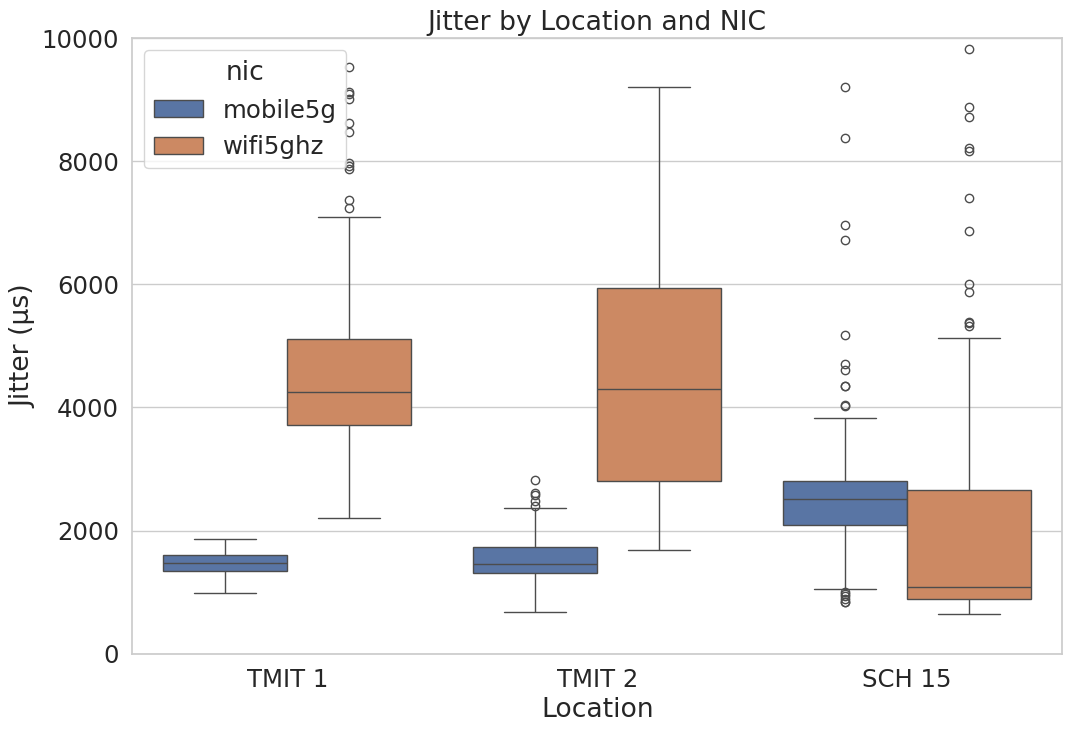

In [5]:
# jitter boxplot
sns.set(style="whitegrid", font_scale=1.6)
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df, x="location", y="jitter_us", hue="nic")
ax.set_ylim(top=10000, bottom=-10)
plt.xlabel("Location")
plt.ylabel("Jitter (μs)")
plt.title("Jitter by Location and NIC")
plt.savefig('figures/jitter_boxplot.png')
plt.show()

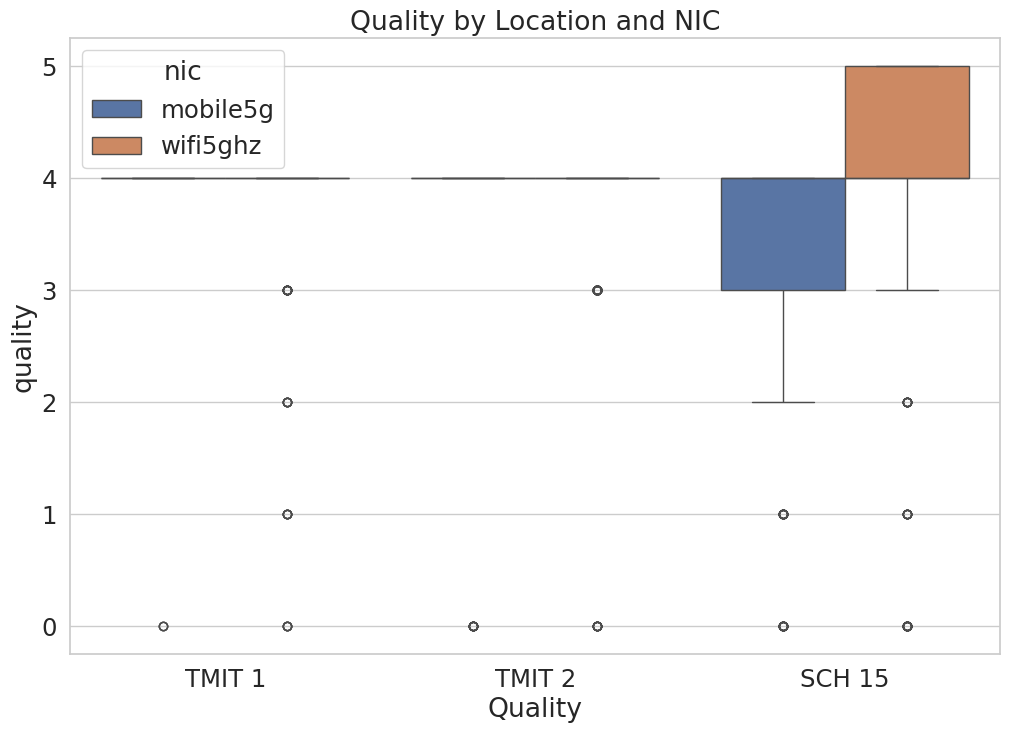

In [6]:
# quality boxplot
sns.set(style="whitegrid", font_scale=1.6)
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df, x="location", y="quality", hue="nic")
#ax.set_ylim(top=120, bottom=-10)
plt.xlabel("Location")
plt.xlabel("Quality")
plt.title("Quality by Location and NIC")
plt.savefig('figures/quality_boxplot.png')
plt.show()

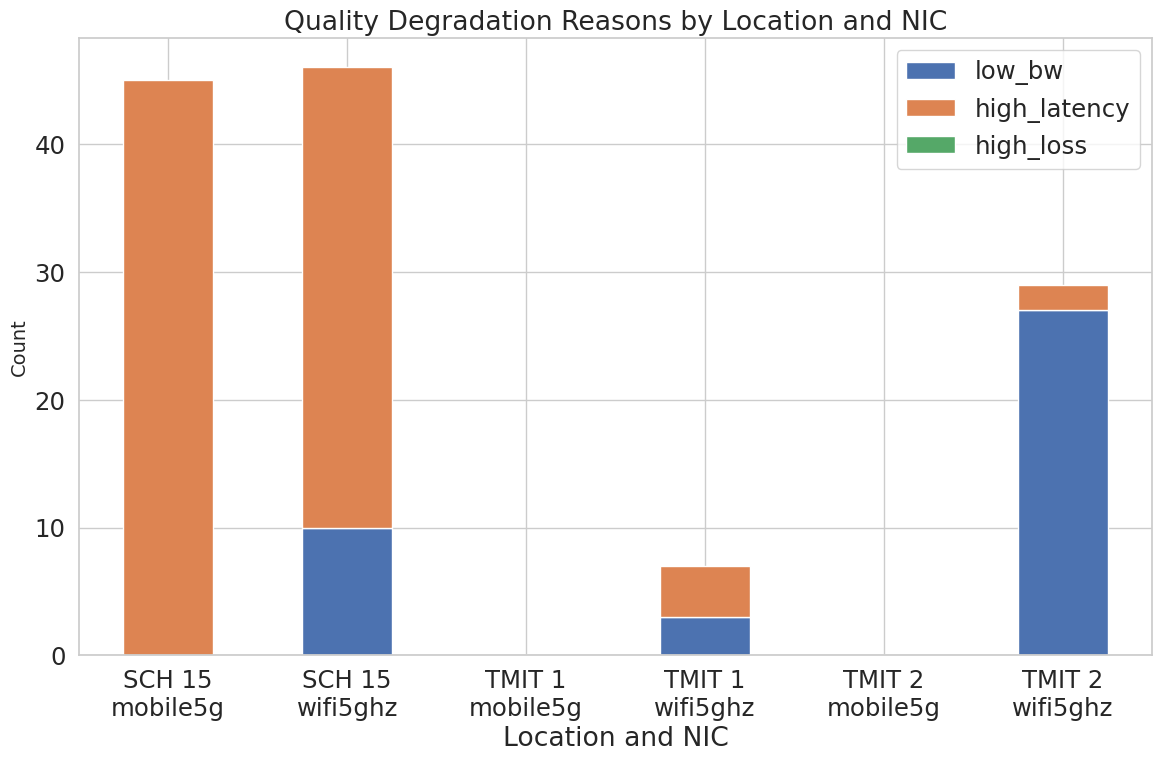

In [ ]:
# quality degradation
df["low_bw"] = df["qualityReasons"].apply(lambda x: x & 0x1 != 0)
df["high_latency"] = df["qualityReasons"].apply(lambda x: x & 0x2 != 0)
df["high_loss"] = df["qualityReasons"].apply(lambda x: x & 0x4 != 0)

summary = df.groupby(["location", "nic"])[["low_bw", "high_latency", "high_loss"]].sum()

summary.index = [f"{loc}\n{nic}" for loc, nic in summary.index]

summary.plot(kind="bar", stacked=True, figsize=(12, 8), title="Quality Degradation Reasons by Location and NIC")

plt.xlabel("Location and NIC")
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=0, ha='center')
plt.yticks()
plt.tight_layout()

plt.savefig('figures/quality_reasons.png')
plt.show()

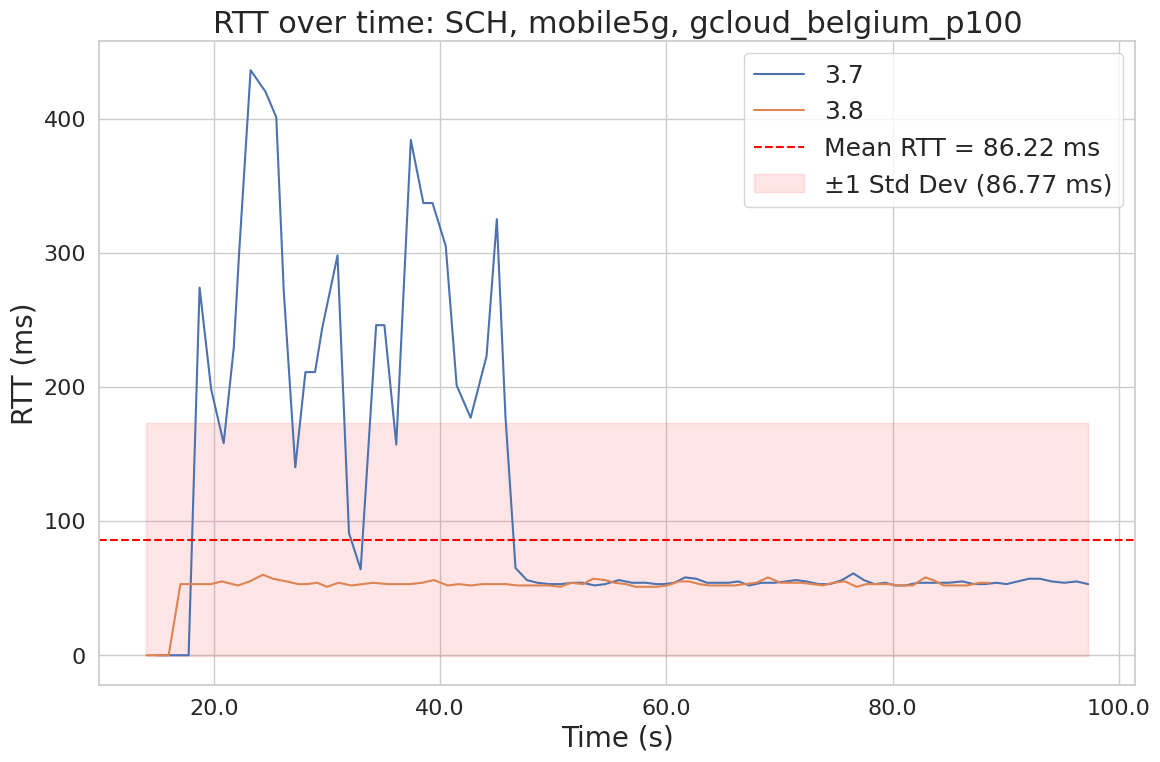

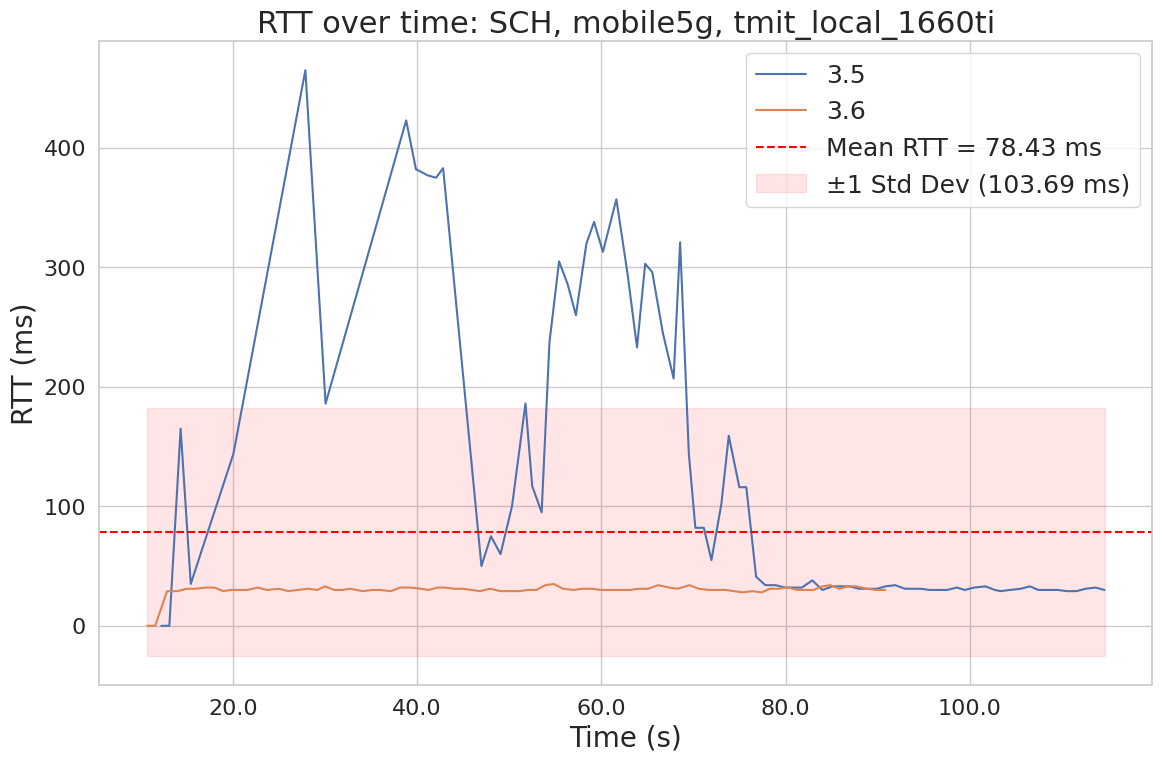

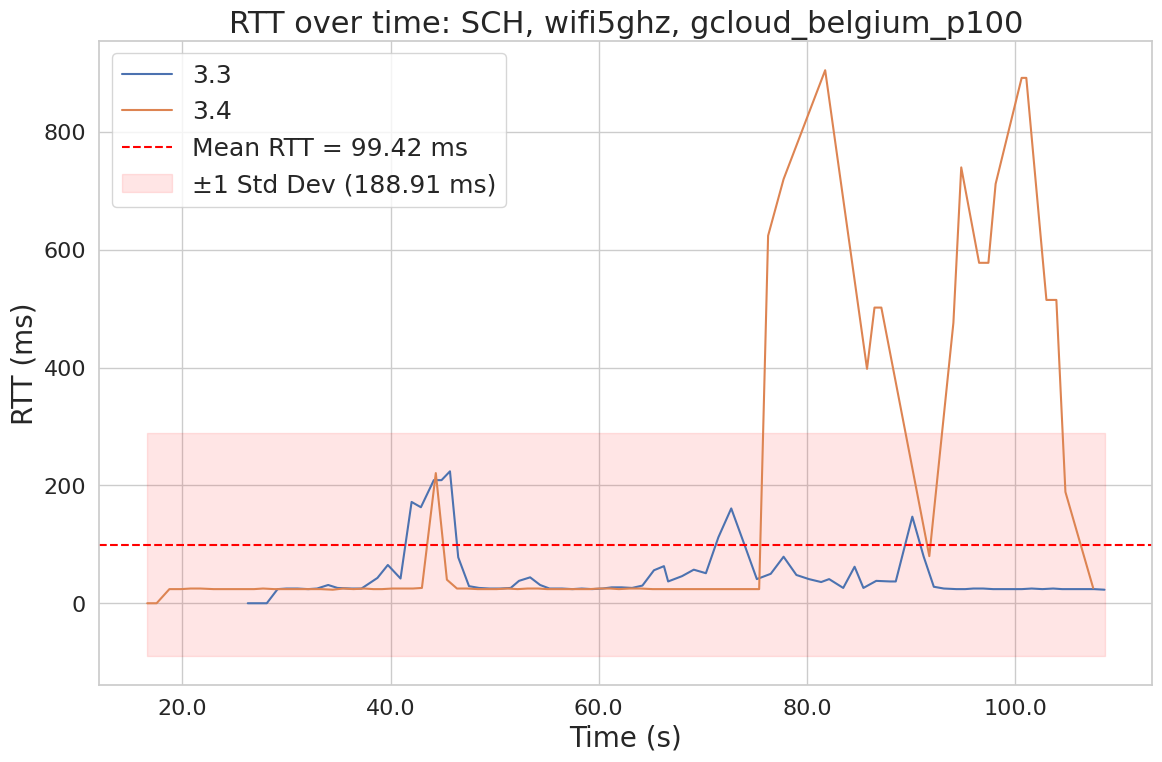

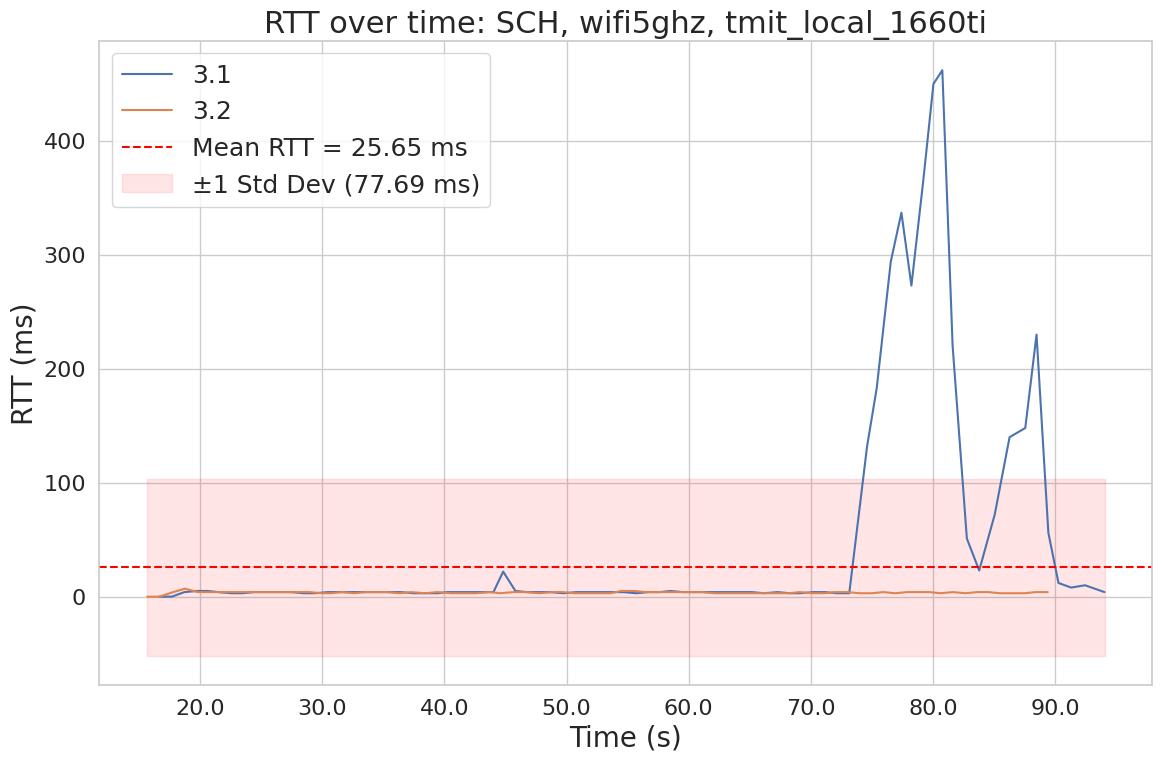

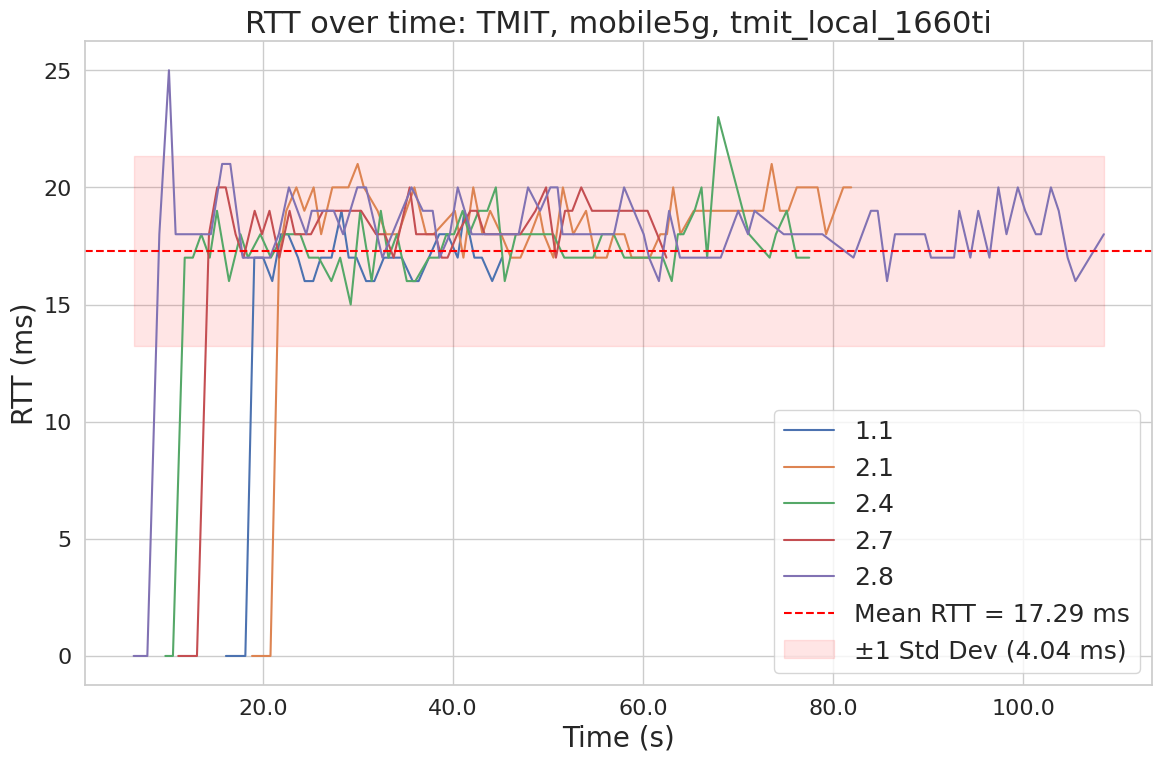

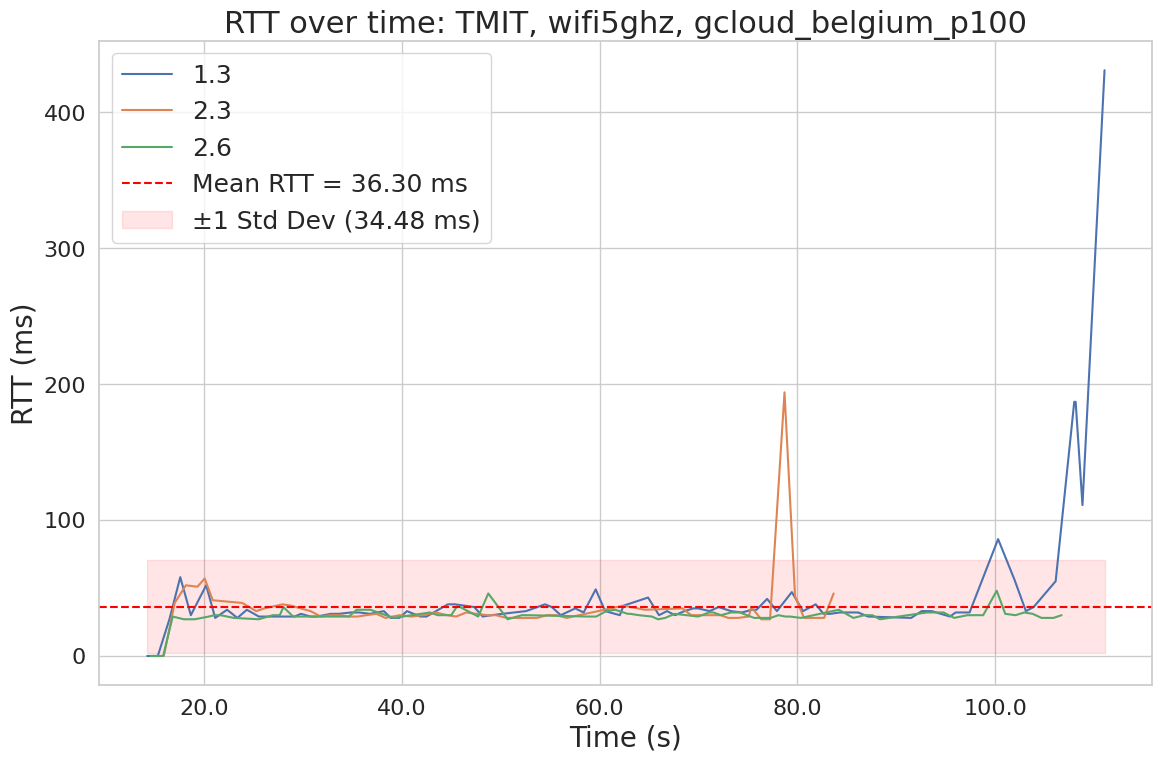

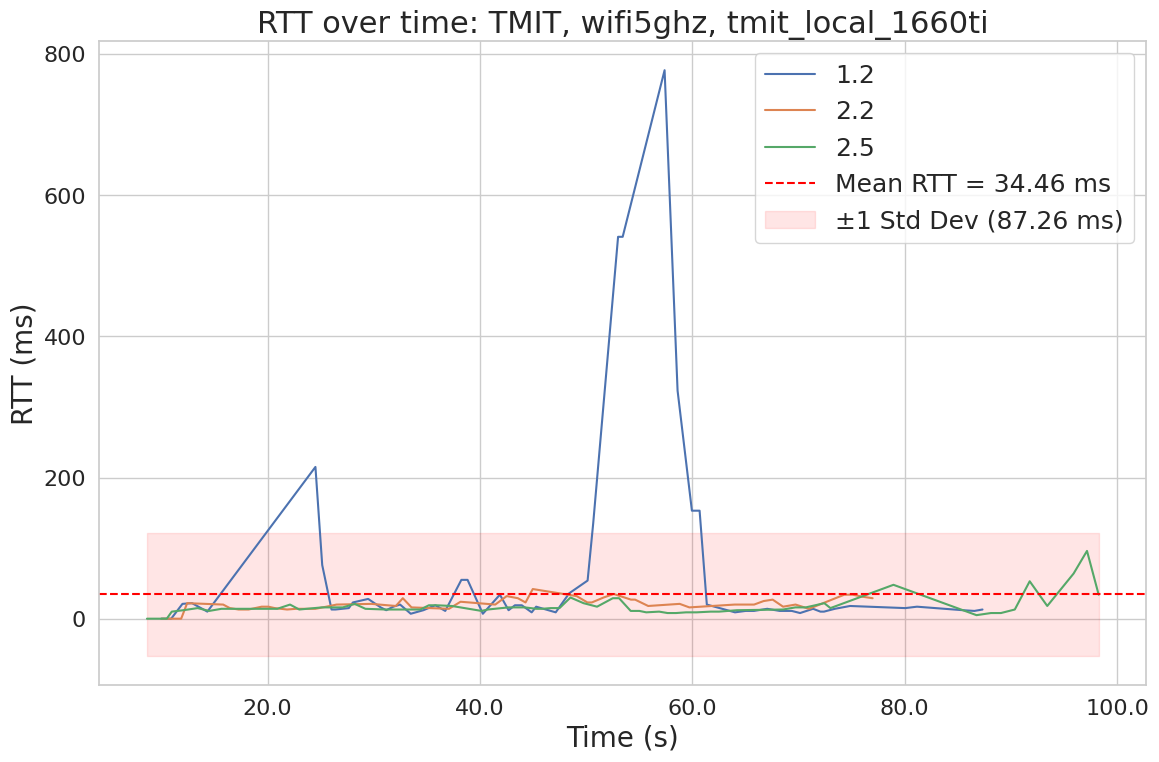

In [8]:
grouped = df.groupby(["location2", "nic", "server_group"])

for (location2, nic, server_group), group in grouped:
    plt.figure(figsize=(12, 8))
    for mid in group["measurement_id"].unique():
        subset = group[group["measurement_id"] == mid]
        plt.plot(subset["time_ms"], subset["rtt_ms"], label=f"{mid}")

    mean_rtt = group["rtt_ms"].mean()
    std_rtt = group["rtt_ms"].std()

    plt.axhline(mean_rtt, color='red', linestyle='--', label=f"Mean RTT = {mean_rtt:.2f} ms")
    x_min = group["time_ms"].min()
    x_max = group["time_ms"].max()
    plt.fill_between(
        [x_min, x_max],
        [mean_rtt - std_rtt] * 2,
        [mean_rtt + std_rtt] * 2,
        color='red',
        alpha=0.1,
        label=f"±1 Std Dev ({std_rtt:.2f} ms)"
    )

    plt.title(f"RTT over time: {location2}, {nic}, {server_group}", fontsize=22)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("RTT (ms)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
    plt.legend(fontsize=18, title_fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/rtt_{location2}_{nic}_{server_group}.png')
    plt.show()

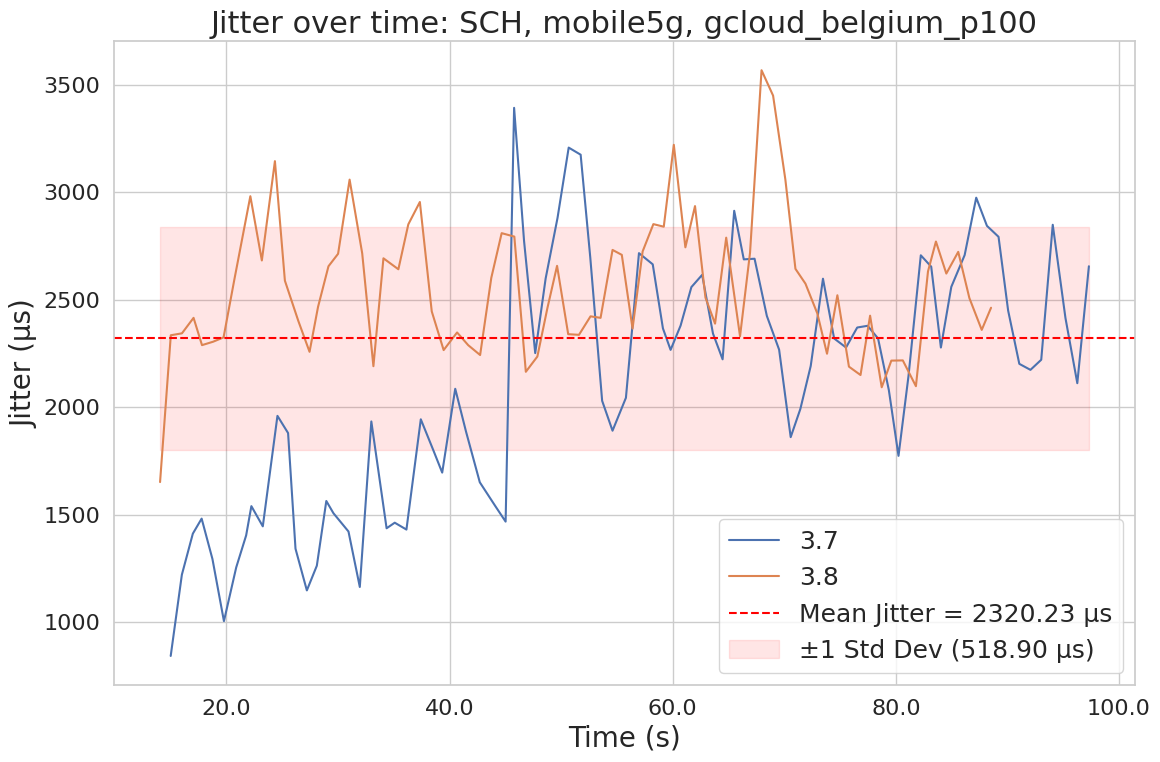

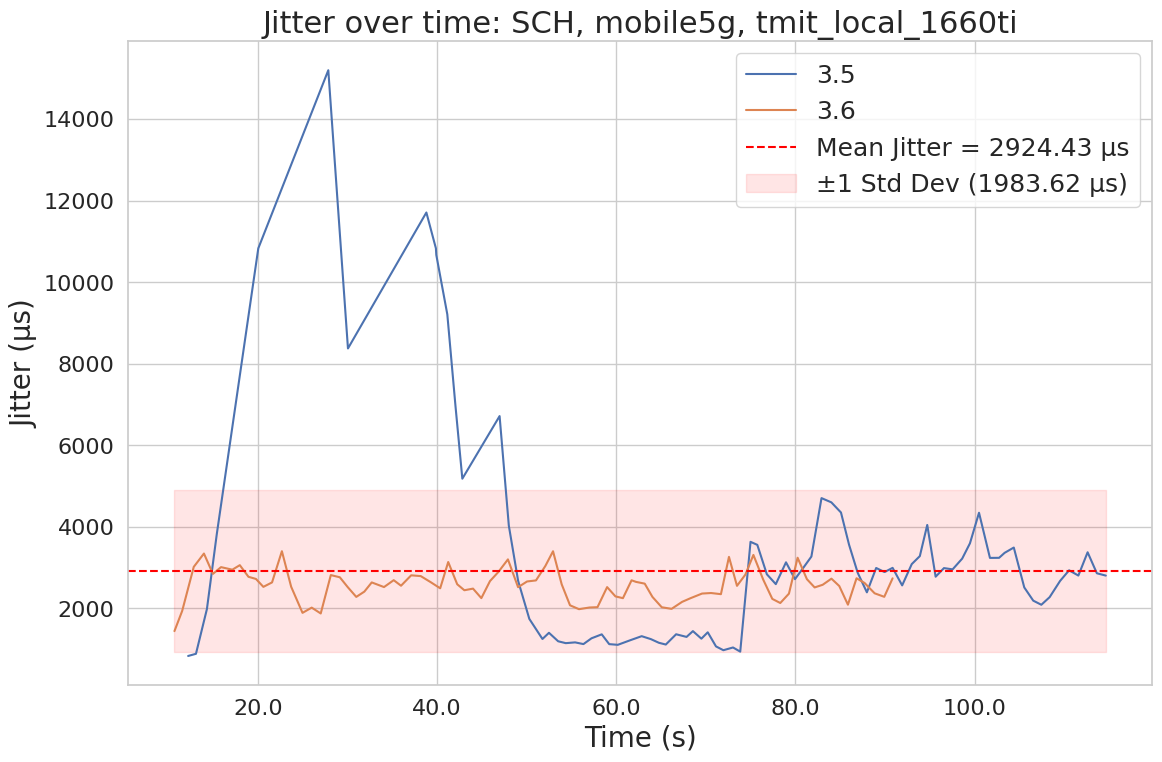

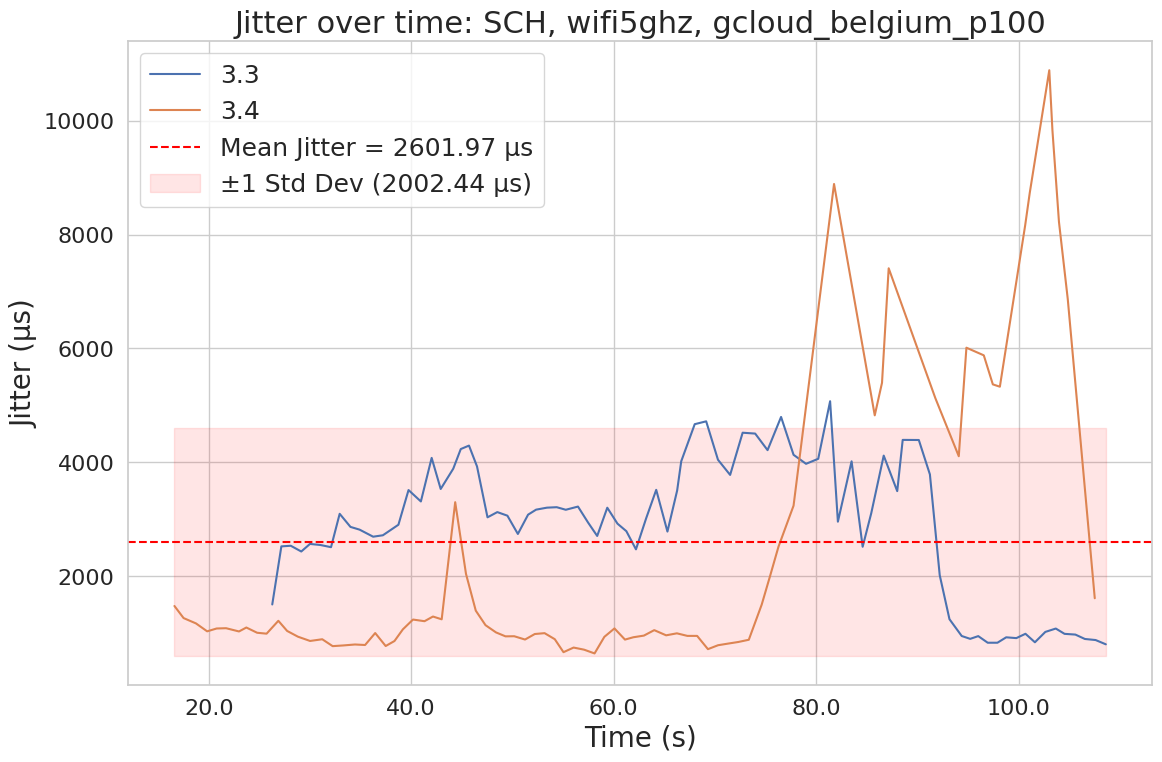

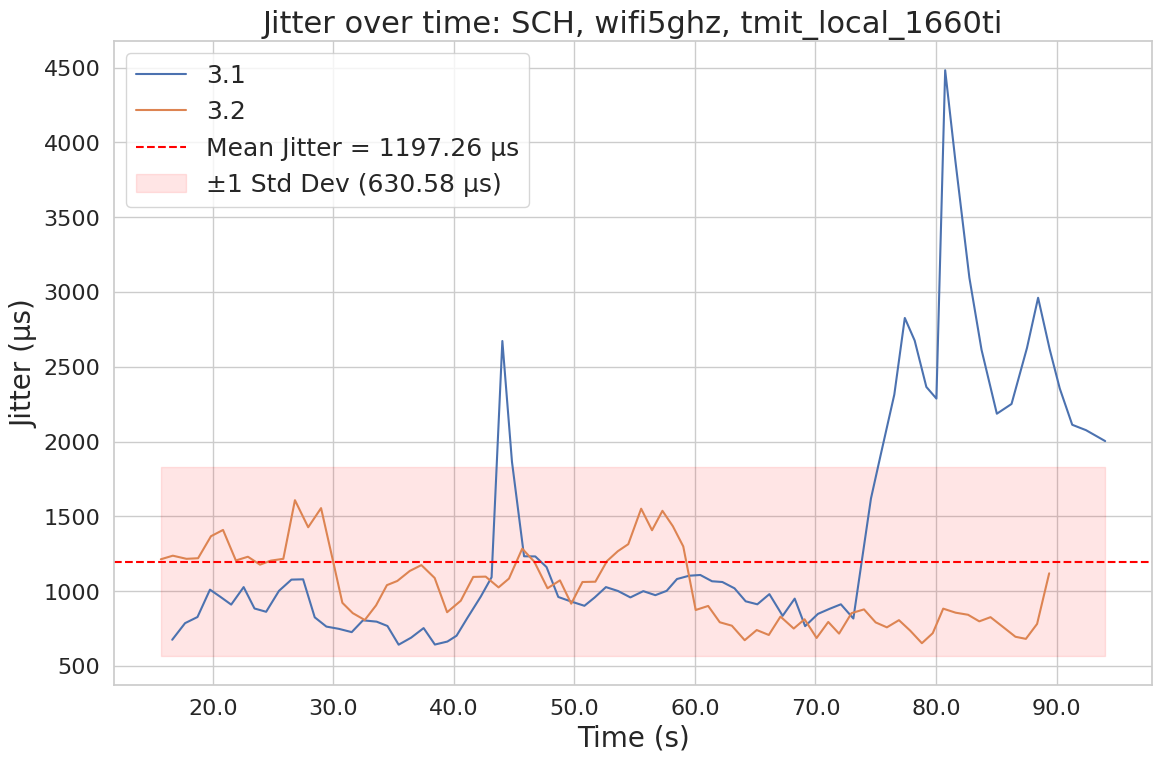

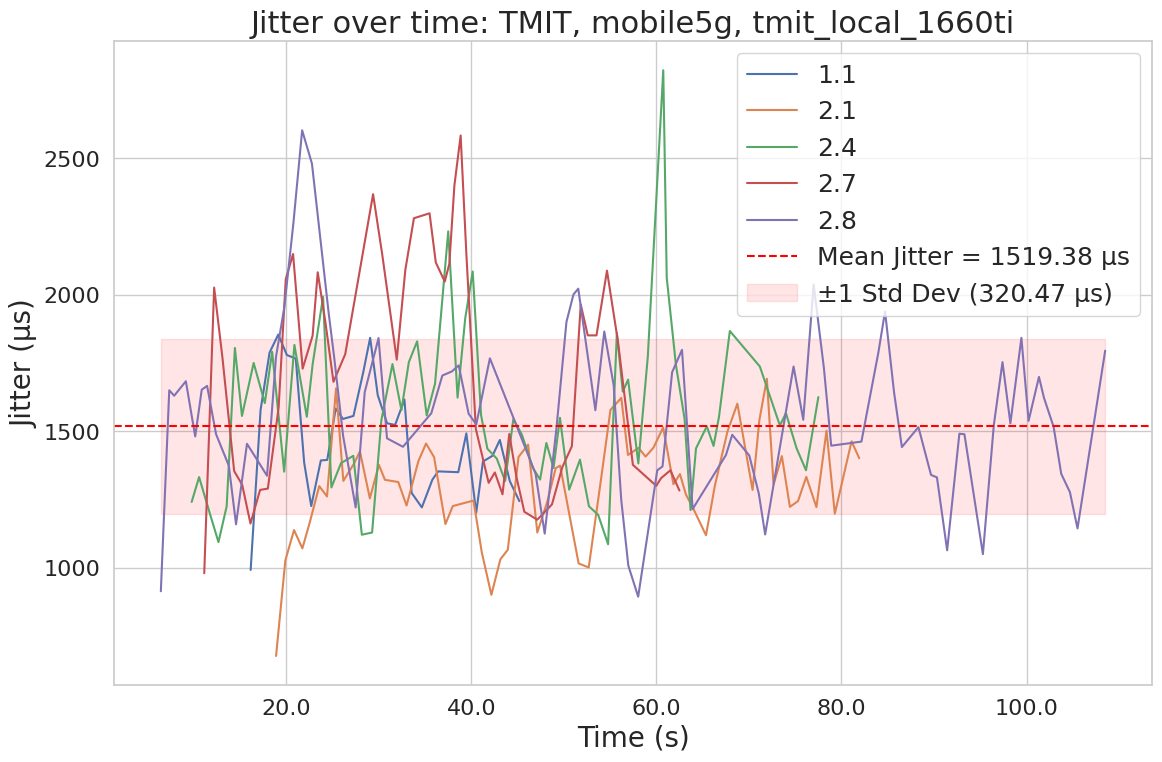

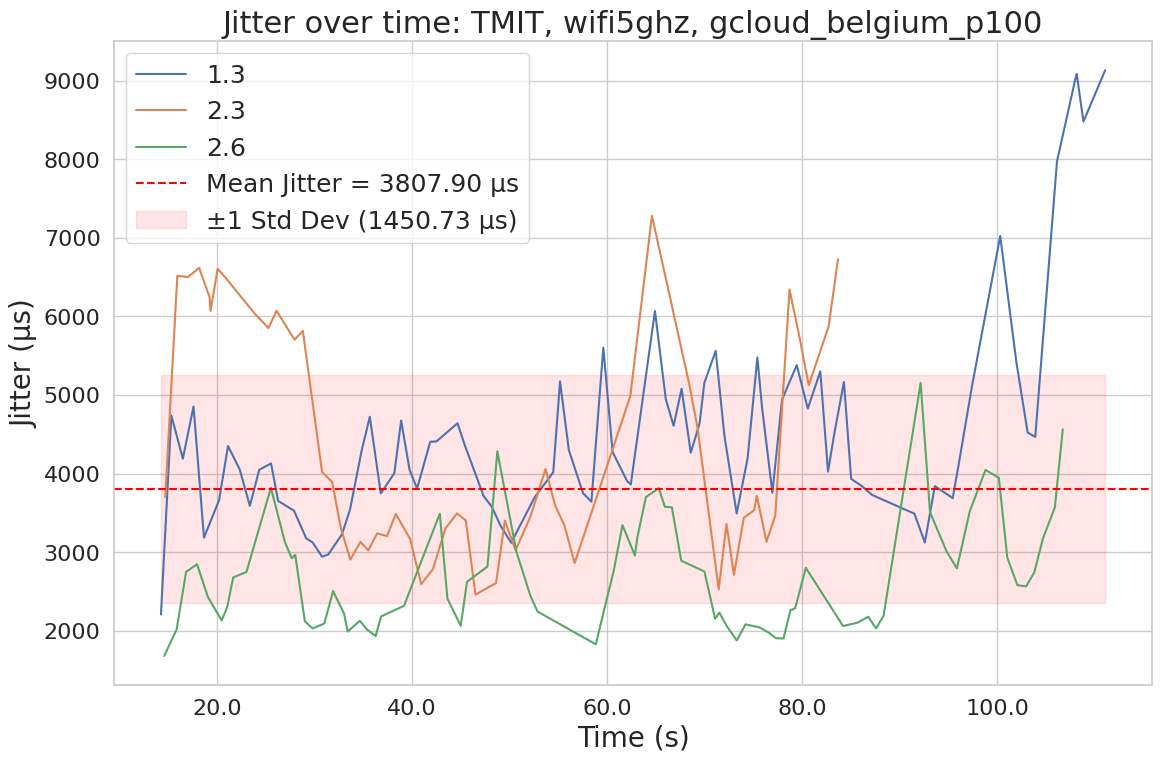

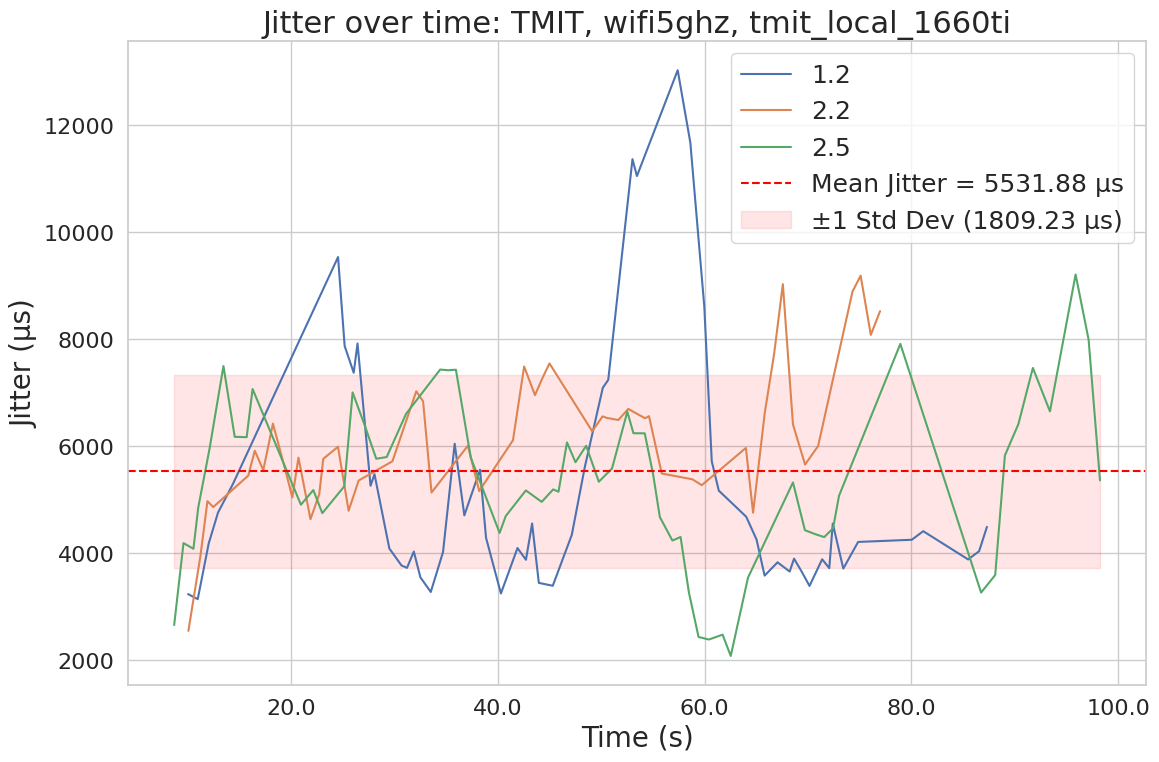

In [9]:
grouped = df.groupby(["location2", "nic", "server_group"])

for (location2, nic, server_group), group in grouped:
    plt.figure(figsize=(12, 8))
    for mid in group["measurement_id"].unique():
        subset = group[group["measurement_id"] == mid]
        plt.plot(subset["time_ms"], subset["jitter_us"], label=f"{mid}")

    mean_jitter = group["jitter_us"].mean()
    std_jitter = group["jitter_us"].std()

    plt.axhline(mean_jitter, color='red', linestyle='--', label=f"Mean Jitter = {mean_jitter:.2f} μs")
    x_min = group["time_ms"].min()
    x_max = group["time_ms"].max()
    plt.fill_between(
        [x_min, x_max],
        [mean_jitter - std_jitter] * 2,
        [mean_jitter + std_jitter] * 2,
        color='red',
        alpha=0.1,
        label=f"±1 Std Dev ({std_jitter:.2f} μs)"
    )

    plt.title(f"Jitter over time: {location2}, {nic}, {server_group}", fontsize=22)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Jitter (μs)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
    plt.legend(fontsize=18, title_fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/jitter_{location2}_{nic}_{server_group}.png')
    plt.show()
